**About** :
In this notebook, I created a model for predicting apartment prices in Mexico City. The goal is not to produce the best possible forecast, but rather to highlight the numerous phases required for creating such a model..

In [1]:
# Import libraries here
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder

Prepare Data

In [2]:
estate = pd.read_csv("/kaggle/input/real-estate/mexico-city-real-estate-1.csv")
estate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4628 entries, 0 to 4627
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   4628 non-null   object 
 1   property_type               4628 non-null   object 
 2   place_with_parent_names     4628 non-null   object 
 3   lat-lon                     4144 non-null   object 
 4   price                       4538 non-null   float64
 5   currency                    4538 non-null   object 
 6   price_aprox_local_currency  4538 non-null   float64
 7   price_aprox_usd             4538 non-null   float64
 8   surface_total_in_m2         1668 non-null   float64
 9   surface_covered_in_m2       4436 non-null   float64
 10  price_usd_per_m2            1150 non-null   float64
 11  price_per_m2                4249 non-null   float64
 12  floor                       291 non-null    float64
 13  rooms                       136 n

Data Wrangling

In [3]:
def wrangle(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Subset data: Apartments in Mexico City ("Distrito Federal") that cost less than $100,000
    df = df[
        (df['place_with_parent_names'].str.contains("Distrito Federal")) &
        (df['price_aprox_usd'] < 100000) &
        (df['property_type'].str.lower() == "apartment")
    ]

    
    # Remove outliers by trimming bottom and top 10% of properties in "surface_covered_in_m2"
    Q1 = df['surface_covered_in_m2'].quantile(0.1)
    Q3 = df['surface_covered_in_m2'].quantile(0.9)
    IQR = Q3 - Q1
    df = df[(df["surface_covered_in_m2"] >= Q1) & (df["surface_covered_in_m2"] <= Q3)]
    #df['surface_covered_in_m2'] = df['surface_covered_in_m2'].clip(lower=Q1 - 1.5 * IQR, upper=Q3 + 1.5 * IQR)
    
    
     # Create separate "lat" and "lon" columns
    df['lat'] = df['lat-lon'].str.split(',', expand=False).str[0].astype(float)
    df['lon'] = df['lat-lon'].str.split(',', expand=False).str[1].astype(float)
    
    # Create "borough" feature from "place_with_parent_names"
    df['borough'] = df['place_with_parent_names'].str.split('|').str[1]
    
    # Drop columns with more than 50% null values
    null_columns = df.columns[df.isnull().any()].tolist()
    df = df.drop(columns=[col for col in null_columns if (df[col].isnull().sum() / len(df) > 0.5)])
     
    df['price_aprox_usd'] = df['price_aprox_usd'].fillna(0)  
    df= df.drop(columns = ['lat-lon','property_type', 'properati_url', 'price', 'currency', 'operation', 'place_with_parent_names', 'price_aprox_local_currency', 'price_per_m2'])
    
    return df

In [4]:
import glob

# Using glob to find all CSV files in the ./data directory except for mexico-city-test-features.csv
files = glob.glob("/kaggle/input/real-estate/mexico-city-real-estate-*.csv")
# Display the list of files
print(files)

['/kaggle/input/real-estate/mexico-city-real-estate-5.csv', '/kaggle/input/real-estate/mexico-city-real-estate-4.csv', '/kaggle/input/real-estate/mexico-city-real-estate-1.csv', '/kaggle/input/real-estate/mexico-city-real-estate-2.csv', '/kaggle/input/real-estate/mexico-city-real-estate-3.csv']


In [5]:
# Use this cell to test your wrangle function and explore the data
df2 = wrangle('/kaggle/input/real-estate/mexico-city-real-estate-1.csv')
df2.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


In [6]:
print("Shape:", df2.shape)

Shape: (1101, 5)


Using glob to create the list files

In [7]:
frames = []
for file in files:
    df= wrangle(file)
    frames.append(df)

print(frames)

[      price_aprox_usd  surface_covered_in_m2        lat        lon  \
1            82737.39                   75.0  19.362690 -99.150565   
3            72197.60                   62.0  19.291345 -99.124312   
4            44277.72                   85.0  19.354987 -99.061709   
13           60589.45                   52.0  19.469681 -99.086136   
18           47429.08                   53.0  19.443592 -99.121407   
...               ...                    ...        ...        ...   
4595         89178.35                   50.0  19.456280 -99.180699   
4599         37758.66                   55.0        NaN        NaN   
4606         36839.97                   50.0  19.441453 -99.160527   
4616         85352.10                   58.0  19.386852 -99.194748   
4618         64979.97                   60.0  19.478647 -99.158017   

                  borough  
1           Benito Juárez  
3                 Tlalpan  
4              Iztapalapa  
13      Gustavo A. Madero  
18    Venustiano C

In [8]:
df = pd.concat((wrangle(file) for file in files), ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 213.9+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,82737.39,75.0,19.362690,-99.150565,Benito Juárez
1,72197.60,62.0,19.291345,-99.124312,Tlalpan
2,44277.72,85.0,19.354987,-99.061709,Iztapalapa
3,60589.45,52.0,19.469681,-99.086136,Gustavo A. Madero
4,47429.08,53.0,19.443592,-99.121407,Venustiano Carranza


EXPLORE the dataset

Text(0.5, 1.0, 'Distribution of Apartment Prices')

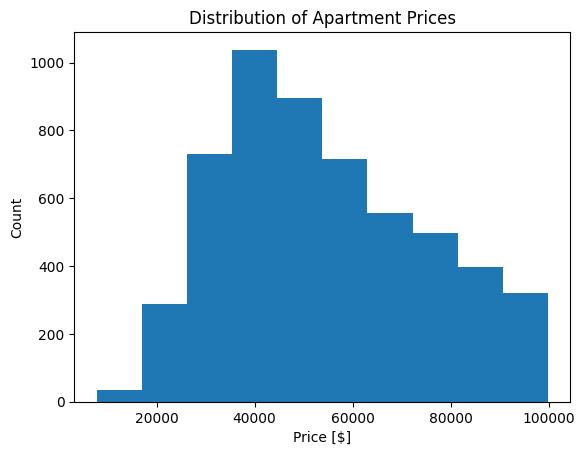

In [9]:
# Build histogram
plt.hist(df["price_aprox_usd"])


# Label axes
plt.xlabel("Price [$]")
plt.ylabel("Count")

# Add title
plt.title("Distribution of Apartment Prices") 

Text(0.5, 1.0, 'Mexico City: Price vs. Area')

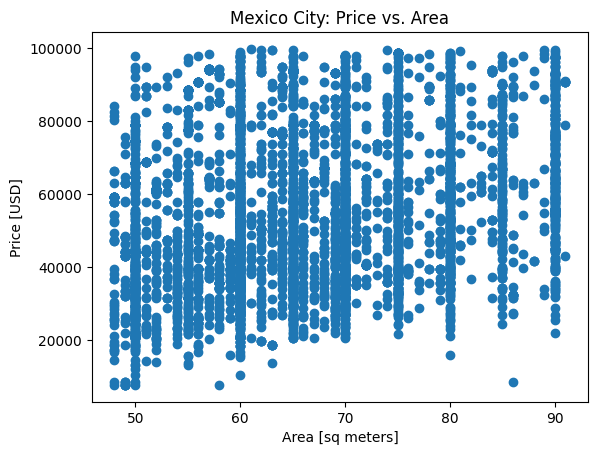

In [10]:
# Build scatter plot
plt.scatter(y = df["price_aprox_usd"], x = df["surface_covered_in_m2"])


# Label axes
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")

# Add title
plt.title("Mexico City: Price vs. Area") 

In [11]:
correlation = df['surface_covered_in_m2'].corr(df['price_aprox_usd'])
print(f'Correlation between Area and Price: {correlation}')

Correlation between Area and Price: 0.2763163303635239


In [12]:
# Plot Mapbox location and price
import plotly.express as px
fig = px.scatter_mapbox(df, 
                        lat="lat", 
                        lon="lon", 
                        color="price_aprox_usd",  # Color by price
                        color_continuous_scale="Viridis",  # Choose color scale
                        mapbox_style="open-street-map",
                        title="Real Estate Prices in Mexico City")
fig.show()

Split

In [13]:
# Split data into feature matrix `X_train` and target vector `y_train`.

X_train = df.drop(columns=["price_aprox_usd"])
y_train = df["price_aprox_usd"]

Build the model

In [14]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print(y_pred_baseline[:5])
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

[54246.5314982642, 54246.5314982642, 54246.5314982642, 54246.5314982642, 54246.5314982642]
Mean apt price: 54246.5314982642
Baseline MAE: 17239.939475888295


In [15]:
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

# Build Model
model = make_pipeline(
        OneHotEncoder(use_cat_names=True),
        SimpleImputer(),
        Ridge(alpha=1.0)
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [16]:
y_pred_training = model.predict(X_train)
mae_training =  mean_absolute_error(y_train, y_pred_training) 
print("Training MAE:", round(mae_training, 2))

Training MAE: 14943.17


In [18]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 18
[  291.65415588   478.90137462 -2492.22181412 13778.18887983
 10319.42980445]
